# Autocodificadores

Fazer um jupyter notebook com autocodificador, a exemplo do exemplo mostrado em aula usando o Keras:

- https://t-adessowiki.fee.unicamp.br/user/aluno/notebooks/ia368z_2s2017/ia368z/deliver-keras/DenseAutoencoder.ipynb

Com as seguintes modificações:

- Utilizar o PyTorch
- Se possível, utilizar um autocodificador convolucional, porém não é imperativo
- Uma vez que o autocodificador seja treinado e o espaço bidimensional seja mostrado dos códigos dos dígitos da base de dados NMIST, gerar novas imagens:
  - mostrar algumas imagens em pontos quaisquer neste espaço bidimensional
  - dados dois pontos neste espaço, mostrar várias imagens, começando no ponto 1 e caminhando numa reta que une os dois pontos, gerar imagens associadas a pontos igualmente espaçados nessa reta, até chegar ao segundo ponto. É se esperar que os números gerados sejam interpolados entre eles.

In [1]:
import torch
import torchvision
import numpy as np
from torch.autograd import Variable

from PIL import Image
from IPython import display
from time import time


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [2]:
#data_train = torchvision.datasets.MNIST('mnist/', train=True)
#data_test  = torchvision.datasets.MNIST('mnist/', train=False)

data_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
]), )

data_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

In [3]:
len(data_train), len(data_test)

(60000, 10000)

In [4]:
data_train.train_data.size(), data_test.test_data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Treinando com pouquíssimos dados

In [5]:
if False:
    n_train_samples = 1000
    n_test_samples = 500
    data_train.train_data = data_train.train_data[:n_train_samples]
    data_test.test_data   = data_test.test_data[:n_test_samples]

In [6]:
data_train.train_data.size(), data_test.test_data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Cria DataLoader

In [7]:
train_loader = torch.utils.data.DataLoader(data_train,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(data_test,
                                         batch_size=500,
                                         shuffle=False,
                                         num_workers=2)

## Visualizando algumas amostras

In [8]:
to_pil = torchvision.transforms.ToPILImage()

for k in range(5):
    x, y = data_test[k]
    display.display(to_pil(x))
    print('label=',y)

label= 7


label= 2


label= 1


label= 0


label= 4


## Definição das classes que representam as redes

In [9]:
import torch.nn.functional as F

# classe do AutoEncoder (Encoder + Decoder)
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# classe do Encoder
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encode_dense1 = torch.nn.Linear(784, 512)
        self.encode_dense2 = torch.nn.Linear(512, 128)
        self.encode_dense3 = torch.nn.Linear(128, 2)

    def forward(self, x):
        x = x.view((-1, 784))
        x = F.relu(self.encode_dense1(x))
        x = F.relu(self.encode_dense2(x))
        x = self.encode_dense3(x)
        return x

# classe do Decoder
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decode_dense1 = torch.nn.Linear(2, 128)
        self.decode_dense2 = torch.nn.Linear(128, 512)
        self.decode_dense3 = torch.nn.Linear(512, 784)

    def forward(self, x):
        x = F.relu(self.decode_dense1(x))
        x = F.relu(self.decode_dense2(x))
        x = self.decode_dense3(x)
        return x

In [10]:
autoencoder = AutoEncoder(Encoder(), Decoder())

## Definição da função de predição

In [11]:
def prediction(loader, model, loss_fn):
    for data in loader:
        images, labels = data
        
        # forward pass
        outputs = model(Variable(images))

        # loss
        loss = loss_fn(outputs, Variable(images))
    return (loss.data[0])

## Treinamento da rede

In [17]:
import copy

epochs = 100
last_epoch = epochs - 1
patience = 10
patience_count = 0
best_model = []
best_val_loss = 9999
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters())

# histórico de acurácia e perda
train_loss = np.empty(epochs)
val_loss = np.empty(epochs)
    
for t in range(epochs):
    start_time = time()
    for i, data in enumerate(train_loader):
        # pega entradas
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels.type(torch.FloatTensor))

        # forward pass
        predict = autoencoder(inputs)

        # loss
        loss = loss_fn(predict, inputs)

        # zera gradiente
        optimizer.zero_grad()
            
        # calcula novos gradientes
        loss.backward()

        # atualiza pesos
        optimizer.step()

    elapsed_time = time() - start_time
    # acurácia e perda o conjunto de treinamento
    train_loss[t] = prediction(train_loader, autoencoder, loss_fn)
    # acurácia e perda no conjunto de validação
    val_loss[t] = prediction(test_loader, autoencoder, loss_fn)
    # imprime dados do treinamento
    print('Epoch:', t, '-',round(elapsed_time,0),'s',
          '\t train loss:', round(train_loss[t],5), 
          '\t val loss:', round(val_loss[t],5))

    # verifica melhora do modelo
    if(best_val_loss > val_loss[t]):
        patience_count = 0
        best_val_loss = val_loss[t]
        best_model = copy.deepcopy(autoencoder)
        print('Loss improved, saving model from epoch', t)

    # early stop
    if(patience_count > patience):
        print('\nEarly stopping as loss did not improve on last', patience, 'epochs!')
        last_epoch = t
        break;

    patience_count += 1

# recupera melhor modelo
autoencoder = best_model
print('Trainning completed!')

Epoch: 0 - 38.0 s 	 train loss: 0.03313 	 val loss: 0.03532
Loss improved, saving model from epoch 0
Epoch: 1 - 39.0 s 	 train loss: 0.03329 	 val loss: 0.0353
Loss improved, saving model from epoch 1
Epoch: 2 - 38.0 s 	 train loss: 0.03443 	 val loss: 0.03484
Loss improved, saving model from epoch 2
Epoch: 3 - 43.0 s 	 train loss: 0.03585 	 val loss: 0.03564
Epoch: 4 - 40.0 s 	 train loss: 0.04247 	 val loss: 0.03476
Loss improved, saving model from epoch 4
Epoch: 5 - 43.0 s 	 train loss: 0.03875 	 val loss: 0.03484
Epoch: 6 - 45.0 s 	 train loss: 0.03488 	 val loss: 0.03494
Epoch: 7 - 45.0 s 	 train loss: 0.03766 	 val loss: 0.0348
Epoch: 8 - 45.0 s 	 train loss: 0.03608 	 val loss: 0.0352
Epoch: 9 - 44.0 s 	 train loss: 0.03282 	 val loss: 0.03484
Epoch: 10 - 47.0 s 	 train loss: 0.03562 	 val loss: 0.03505
Epoch: 11 - 45.0 s 	 train loss: 0.03654 	 val loss: 0.0348
Epoch: 12 - 46.0 s 	 train loss: 0.03706 	 val loss: 0.03477
Epoch: 13 - 47.0 s 	 train loss: 0.03894 	 val loss: 0.03

## Fazendo encoding do conjunto de testes

In [18]:
data_test_encoded = []

for data in test_loader:
    images, labels = data
        
    # forward pass
    data_test_encoded.append(autoencoder.encoder(Variable(images)).data.numpy())
    
data_test_encoded = np.array(data_test_encoded).reshape(10000,2)

## Mostrando encoding das imagens no espaço 2D

In [19]:
%matplotlib inline
import matplotlib.pyplot as plot

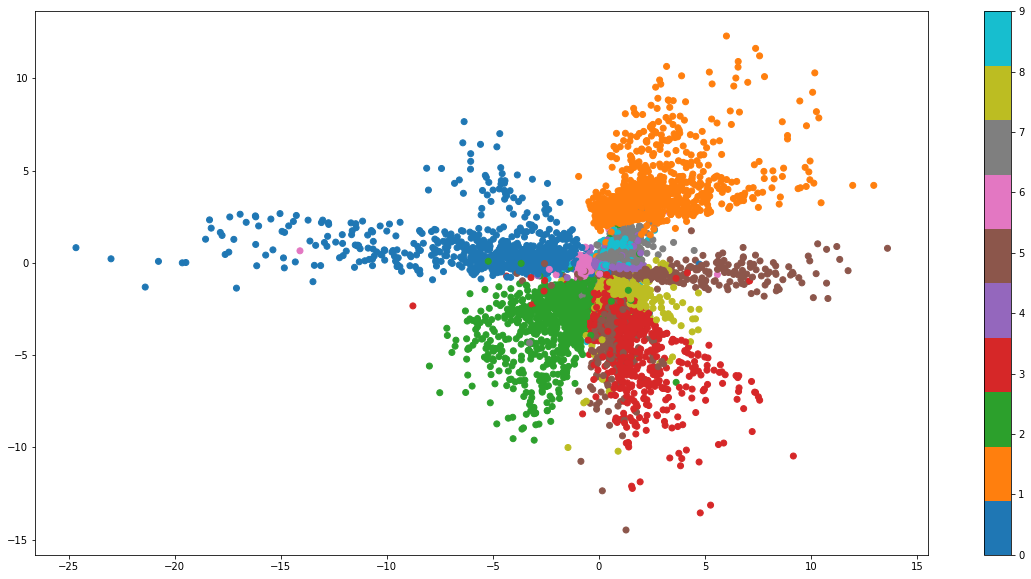

In [20]:
plot.figure(figsize=(20, 10))
plot.scatter(data_test_encoded[:, 0], data_test_encoded[:, 1], c=data_test.test_labels.numpy(), cmap=plot.cm.tab10)
plot.colorbar();

## Mostrando uma imagem decodificada de pontos no plano 2D

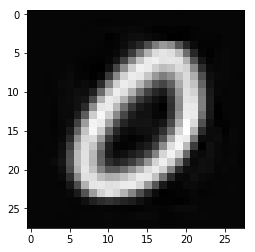

In [21]:
xy = [-4, -0]
point = torch.Tensor(xy).view(-1,2)
point_decoded = autoencoder.decoder(Variable(point))
point_decoded = point_decoded.view(28, 28)
point_decoded = point_decoded.data.numpy()
plot.gray()
plot.imshow(point_decoded)

## Criando conjunto de pontos entre min(x,y) e max(x,y) e fazendo decoding

In [22]:
total = 50
x = np.linspace(min(data_test_encoded[:, 0]), max(data_test_encoded[:, 0]), total)
y = np.linspace(min(data_test_encoded[:, 1]), max(data_test_encoded[:, 1]), total)

points = np.concatenate((x.reshape(total,1),y.reshape(total,1)), axis=1)
points = torch.Tensor(points)
points.size()

torch.Size([50, 2])

## Mostrando decoding das imagens no espaço 2D

In [23]:
data_test_decoded = autoencoder.decoder(Variable(points))
data_test_decoded = data_test_decoded.view(-1, 28, 28)
data_test_decoded = data_test_decoded.data.numpy()
data_test_decoded.shape

(50, 28, 28)

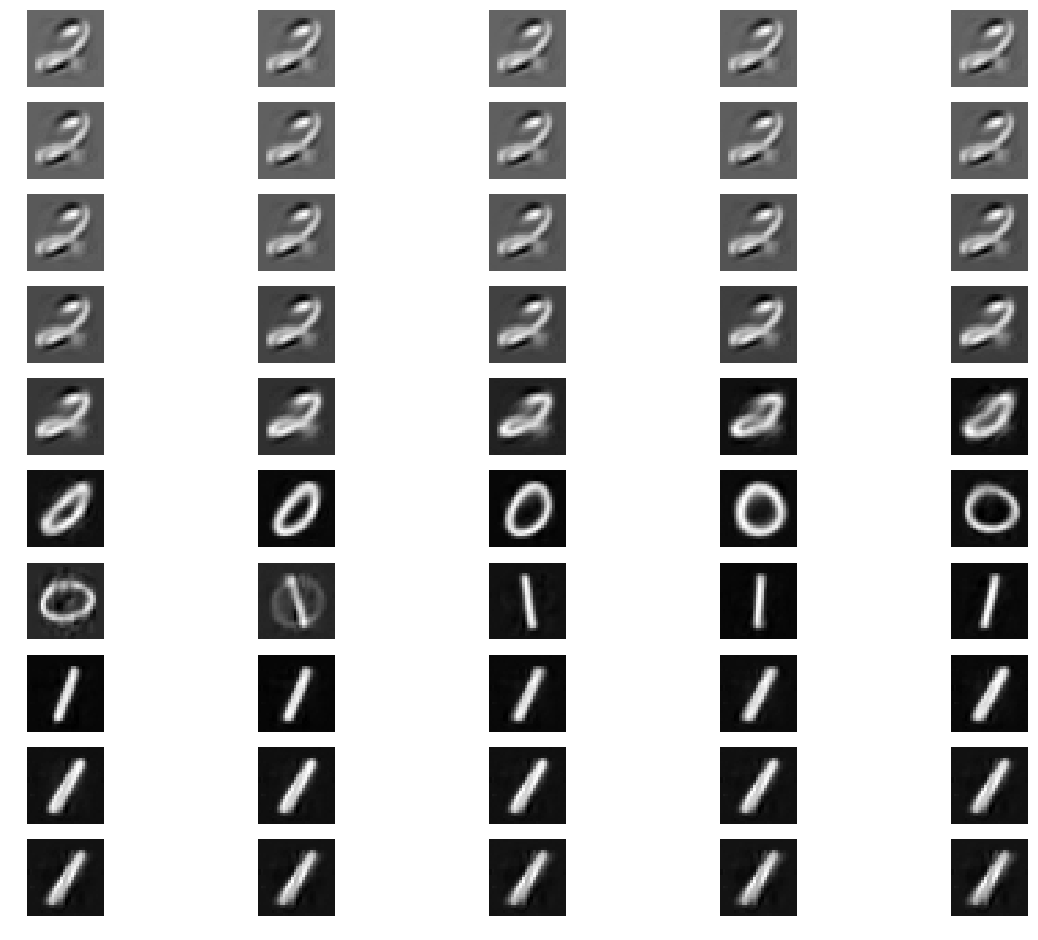

In [24]:
k = 0
fig, ax = plot.subplots(int(total/5), 5, figsize=(20, total/3))

for i in range(0,int(total/5)):
    for j in range(5):
        # display reconstruction
        ax[i,j].imshow(data_test_decoded[k])
        ax[i,j].axis('off')
        k = k+1
        
plot.show()